In [2]:
%load_ext autoreload
%autoreload 2

import os
import os.path as osp

from PointNet import PointNet
import numpy as np
import torch
from datasets.hitgraphs import HitGraphDatasetG
from datasets.graph import draw_sample_point
from torch_geometric.data import DataLoader

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
model_fname = "tau_07aug/PointNet_1397602_26d89c5565_sitonga.20190807.164252.best.pth"

path = osp.join(osp.dirname(os.path.abspath('.')), '..', 'data', 'npz','partGun_PDGid15_x1000_Pt3.0To100.0_NTUP_1')
full_dataset = HitGraphDatasetG(path)
fulllen = len(full_dataset)

d = full_dataset
num_classes = d[0].y.max().item() + 1 if d[0].y.dim() == 1 else d[0].y.size(1)
num_classes = int(num_classes)
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
model = PointNet(num_classes).to(device)
model.load_state_dict(torch.load(model_fname))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [58]:
evt_index = 340

test_dataset = torch.utils.data.Subset(full_dataset,[evt_index])
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)




for i,data in enumerate(test_loader):
    assert (i == 0);
    x=(data.x.cpu().detach().numpy())
    pos =(data.pos.cpu().detach().numpy())
    y=(data.y.cpu().detach().numpy())
    data = data.to(device)
    out = (model(data).max(dim=1)[1].cpu().detach().numpy())
    assert(y.shape == out.shape)
    


print(y)
print(out)


[1 1 1 ... 0 0 0]
[1 1 1 ... 1 1 1]


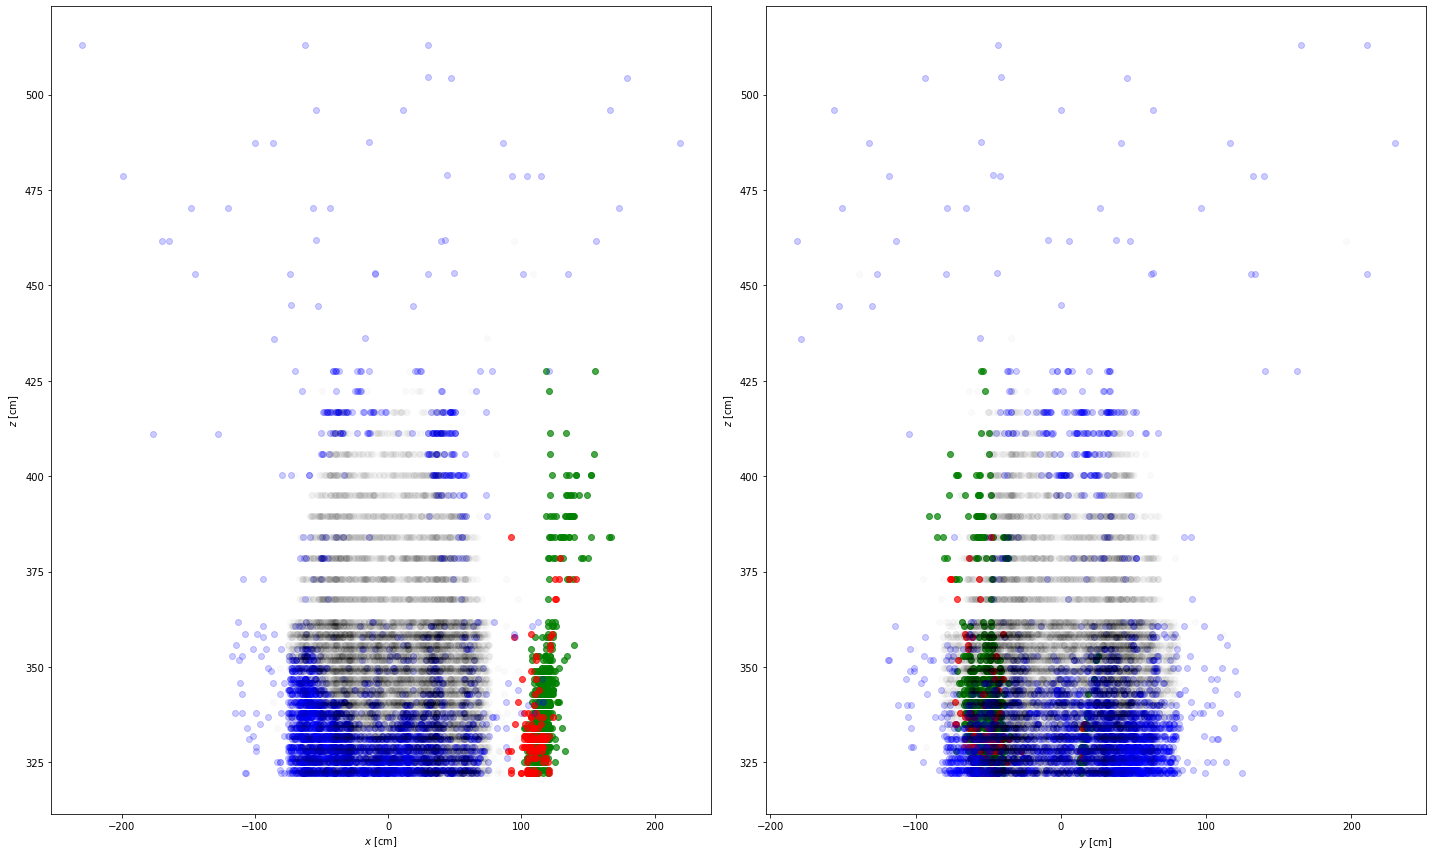

In [59]:
draw_sample_point(pos, y, out);